<a href="https://colab.research.google.com/github/Chizara69/rosee.github.io/blob/main/Asses_Identifying_Offensive_Posts_In_Social_Media_RoselineE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict nature of Social Media Posts

This blog contains steps to train a machine-learning model to predict the nature of a tweet, whether it is:-
1.   Not Offensive (NOT): Posts that do not contain offense or profanity
2.   Targeted Insult (TIN): Posts containing insult/threat to an individual, a group, or other.
3.   Untargeted (UNT): Posts containing nontargeted



By: Roseline Ezeako



# Importing Data Libraries & Modules

In [ ]:
# Data
import pandas as pd
import numpy as np
from sklearn.utils import resample

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# Data processing incl. modules
import nltk
import re
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("stopwords")

# Text Preprocessing
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# feature extraction & Split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# libraries for ML algorithms
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

# Evaluation
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# libraries for data plotting
import seaborn as sns
import matplotlib.pyplot as plt

RANDOM_SEED = 100



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#Loading the Training & Testing Data files with Basic EDA

A data folder was provided which included two csv files (i.train.csv, ii. test.csv with the following:-

| Data     | Features | Entries |
|----------|-----|--------|
| train     | id, tweet, label  | 13240   |
| test    | id, tweet, label  | 460 |



In [ ]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

# Data Exploration

In [ ]:
# Lets look at the number of instances & features
print(df_train.shape)
print(df_test.shape)

(13240, 3)
(460, 2)


In [ ]:
# Lets look at the 1st five rows of training data
df_train.head()

,id,tweet,label
0,86426,@USER She should ask a few native Americans wh...,UNT
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,TIN
2,16820,Amazon is investigating Chinese employees who ...,NOT
3,62688,"@USER Someone should'veTaken"" this piece of sh...",UNT
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT


<Axes: xlabel='label', ylabel='count'>

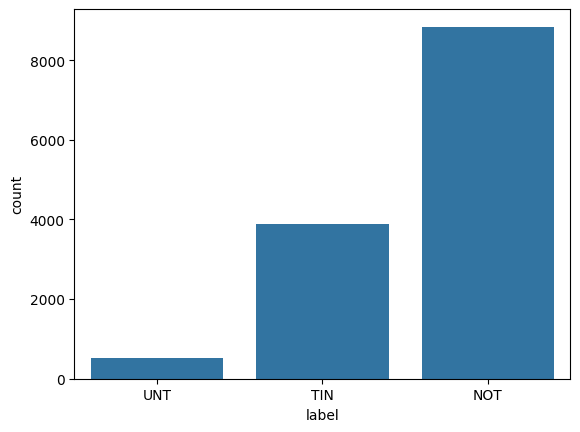

In [ ]:
# training_data Class distrubtion
sns.countplot(x=df_train["label"])

In [ ]:
counts = df_train['label'].value_counts()
print(counts)

NOT    8840
TIN    3876
UNT     524
Name: label, dtype: int64


In [ ]:
# Checking for missing values
df_train.isnull().sum()

id       0
tweet    0
label    0
dtype: int64

# Performing up sampling
To deal with the issue of imbalanced data, we will increase the samples of the minority classes to match the majority class.

In [ ]:
# Create different dataframes for each class
df_NOT = df_train[df_train['label'] == 'NOT']
df_TIN = df_train[df_train['label'] == 'TIN']
df_UNT = df_train[df_train['label'] == 'UNT']

# Determine the size of the majority class
majority_size = max(len(df_NOT), len(df_TIN), len(df_UNT))

# Upsample minority classes to match the size of the majority class
df_NOT_upsampled = resample(df_NOT, replace=True, n_samples=majority_size,random_state=42)
df_TIN_upsampled = resample(df_TIN, replace=True, n_samples=majority_size,random_state=42)
df_UNT_upsampled = resample(df_UNT, replace=True, n_samples=majority_size,random_state=42)

# upsampled minority classes combined with the majority class
df_upsampled = pd.concat([df_NOT_upsampled, df_TIN_upsampled, df_UNT_upsampled])


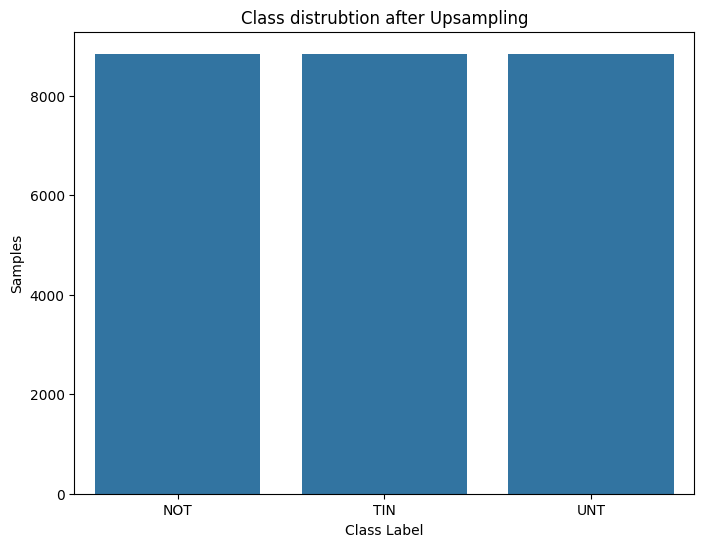

In [ ]:
# New upsampled data Class distrubtion
plt.figure(figsize=(8, 6))
sns.countplot(data=df_upsampled, x='label')
plt.title('Class distrubtion after Upsampling')
plt.xlabel('Class Label')
plt.ylabel('Samples')
plt.show()

In [ ]:
df_train=df_upsampled

In [ ]:
df_train.count()

id       26520
tweet    26520
label    26520
dtype: int64

In [ ]:
df_train.head()

,id,tweet,label
10882,67168,@USER @USER @USER @USER @USER @USER @USER @USE...,NOT
1298,33060,@USER @USER The men senators should allow citi...,NOT
8067,82723,@USER #Republicans #Conservatives #Independent...,NOT
7768,10582,@USER @USER Please could the author of this br...,NOT
8593,59391,#MAGA Why she not being prosecuted? URL,NOT


# Data Preprocessing

Tokenizing Training data in the Tweet column


In [ ]:
'''Intializing the tokenizer where tokens:-
1. are note case sensitive
2. reduces the length
3. removes usernames'''
tknzr = TweetTokenizer(preserve_case=False,reduce_len=True,strip_handles=True)

In [ ]:
tokenized_tweet_train = [tknzr.tokenize(text) for text in df_train['tweet']]
# Print the first 10 tweets
print(tokenized_tweet_train[:5])

[['another', 'great', 'train', 'picked', 'up', 'some', 'new', 'patriots', '.', 'thank', 'you', 'for', 'including', 'me', '.'], ['the', 'men', 'senators', 'should', 'allow', 'citizens', 'to', 'question', 'the', 'accuser', '.', 'the', 'citizens', 'should', 'be', 'women', 'and', 'conservatives', 'who', 'love', 'america', 'and', 'fairness', '.'], ['#republicans', '#conservatives', '#independents', 'listen', '👂', 'up', 'the', '#hillarites', '#democrats', 'are', 'repeating', '#history', "don't", 'stand', 'for', 'it', '.', '#confirmkavanaugh', 'now', '!', 'url'], ['please', 'could', 'the', 'author', 'of', 'this', 'brill', 'article', 'do', 'something', 'to', 'rescue', 'us', 'and', 'brexit', 'from', 'this', 'remainiac', 'of', 'a', 'pm', 'who', 'will', 'enslave', 'us', 'forever', 'under', 'unelected', 'commsion', 'federal', 'fanatics', 'plus', 'the', 'conservatives', 'can', 'say', 'farewell', 'to', 'gov', 'for', 'at', 'least', '5', 'yrs', '.', 'who', 'could', 'trust', 'the', 'tories', '?'], ['#m

In [ ]:
# join tokenized tweets back together
Tweet_train_sentence = [" ".join(tokens) for tokens in tokenized_tweet_train]
#print(Tweet_train_sentence)

# Add tokenized tweet sentences to dataframe
df_train["Tokenized_Tweets"] = Tweet_train_sentence

In [ ]:
df_train.head()

,id,tweet,label,Tokenized_Tweets
10882,67168,@USER @USER @USER @USER @USER @USER @USER @USE...,NOT,another great train picked up some new patriot...
1298,33060,@USER @USER The men senators should allow citi...,NOT,the men senators should allow citizens to ques...
8067,82723,@USER #Republicans #Conservatives #Independent...,NOT,#republicans #conservatives #independents list...
7768,10582,@USER @USER Please could the author of this br...,NOT,please could the author of this brill article ...
8593,59391,#MAGA Why she not being prosecuted? URL,NOT,#maga why she not being prosecuted ? url


# Regular Expressions

In [ ]:
# A regular expression function was defined to remove hashtags and the words attached to them, and special characters excluding period, comma, apostrophe and hyphen
def remove_hashtags_and_special_chars(Tokenized_Tweets):
    # Remove hashtags and words attached to them
    Tokenized_Tweets = re.sub(r'#\w+\s*', '', Tokenized_Tweets)
    # Remove special characters excluding period, comma, and apostrophe
    Tokenized_Tweets = re.sub(r'[^\w\s.,\'-]', '', Tokenized_Tweets)
    return Tokenized_Tweets

# Apply the function to the "Tokenized_Tweets"
df_train["Tokenized_Tweets_Plus_RegEx"] = df_train["Tokenized_Tweets"].apply(remove_hashtags_and_special_chars)

In [ ]:
df_train.head()

,id,tweet,label,Tokenized_Tweets,Tokenized_Tweets_Plus_RegEx
10882,67168,@USER @USER @USER @USER @USER @USER @USER @USE...,NOT,another great train picked up some new patriot...,another great train picked up some new patriot...
1298,33060,@USER @USER The men senators should allow citi...,NOT,the men senators should allow citizens to ques...,the men senators should allow citizens to ques...
8067,82723,@USER #Republicans #Conservatives #Independent...,NOT,#republicans #conservatives #independents list...,listen up the are repeating don't stand for i...
7768,10582,@USER @USER Please could the author of this br...,NOT,please could the author of this brill article ...,please could the author of this brill article ...
8593,59391,#MAGA Why she not being prosecuted? URL,NOT,#maga why she not being prosecuted ? url,why she not being prosecuted url


# Text Normalisation
So far, we haven Tokenised the tweets with the parameter that includes lower casing and added a regular expression  Lets look at normalising the text using Lemmatisation.

In [ ]:
wnl = WordNetLemmatizer()

list_lemmatised_tweets = []

# iterate through each list of tokens and lemmatise the tokens
for tokens in tokenized_tweet_train:
  lemma_words = [wnl.lemmatize(word) for word in tokens]
  lemma_sentence = ' '.join(lemma_words)
  list_lemmatised_tweets.append(lemma_sentence)

print(list_lemmatised_tweets[:2])

# add new column to data frame
df_train['Lemmatised_Tweets'] = list_lemmatised_tweets

df_train.head()

['another great train picked up some new patriot . thank you for including me .', 'the men senator should allow citizen to question the accuser . the citizen should be woman and conservative who love america and fairness .']


,id,tweet,label,Tokenized_Tweets,Tokenized_Tweets_Plus_RegEx,Lemmatised_Tweets
10882,67168,@USER @USER @USER @USER @USER @USER @USER @USE...,NOT,another great train picked up some new patriot...,another great train picked up some new patriot...,another great train picked up some new patriot...
1298,33060,@USER @USER The men senators should allow citi...,NOT,the men senators should allow citizens to ques...,the men senators should allow citizens to ques...,the men senator should allow citizen to questi...
8067,82723,@USER #Republicans #Conservatives #Independent...,NOT,#republicans #conservatives #independents list...,listen up the are repeating don't stand for i...,#republicans #conservatives #independents list...
7768,10582,@USER @USER Please could the author of this br...,NOT,please could the author of this brill article ...,please could the author of this brill article ...,please could the author of this brill article ...
8593,59391,#MAGA Why she not being prosecuted? URL,NOT,#maga why she not being prosecuted ? url,why she not being prosecuted url,#maga why she not being prosecuted ? url


In [ ]:
tokenized_tweet_train_regex = [tknzr.tokenize(text) for text in df_train['Tokenized_Tweets_Plus_RegEx']]
# Print the first 5 tweets
print(tokenized_tweet_train_regex[:5])

[['another', 'great', 'train', 'picked', 'up', 'some', 'new', 'patriots', '.', 'thank', 'you', 'for', 'including', 'me', '.'], ['the', 'men', 'senators', 'should', 'allow', 'citizens', 'to', 'question', 'the', 'accuser', '.', 'the', 'citizens', 'should', 'be', 'women', 'and', 'conservatives', 'who', 'love', 'america', 'and', 'fairness', '.'], ['listen', 'up', 'the', 'are', 'repeating', "don't", 'stand', 'for', 'it', '.', 'now', 'url'], ['please', 'could', 'the', 'author', 'of', 'this', 'brill', 'article', 'do', 'something', 'to', 'rescue', 'us', 'and', 'brexit', 'from', 'this', 'remainiac', 'of', 'a', 'pm', 'who', 'will', 'enslave', 'us', 'forever', 'under', 'unelected', 'commsion', 'federal', 'fanatics', 'plus', 'the', 'conservatives', 'can', 'say', 'farewell', 'to', 'gov', 'for', 'at', 'least', '5', 'yrs', '.', 'who', 'could', 'trust', 'the', 'tories'], ['why', 'she', 'not', 'being', 'prosecuted', 'url']]


In [ ]:
wnl = WordNetLemmatizer()

list_lemmatised_tweets_regex = []

# iterate through each list of tokens and lemmatise the tokens
for tokens in tokenized_tweet_train_regex:
  lemma_words = [wnl.lemmatize(word) for word in tokens]
  lemma_sentence = ' '.join(lemma_words)
  list_lemmatised_tweets_regex.append(lemma_sentence)

print(list_lemmatised_tweets_regex[:2])

# add new column to data frame
df_train['Lemmatised_Tweets_Plus_RegEx'] = list_lemmatised_tweets_regex

df_train.head()

['another great train picked up some new patriot . thank you for including me .', 'the men senator should allow citizen to question the accuser . the citizen should be woman and conservative who love america and fairness .']


,id,tweet,label,Tokenized_Tweets,Tokenized_Tweets_Plus_RegEx,Lemmatised_Tweets,Lemmatised_Tweets_Plus_RegEx
10882,67168,@USER @USER @USER @USER @USER @USER @USER @USE...,NOT,another great train picked up some new patriot...,another great train picked up some new patriot...,another great train picked up some new patriot...,another great train picked up some new patriot...
1298,33060,@USER @USER The men senators should allow citi...,NOT,the men senators should allow citizens to ques...,the men senators should allow citizens to ques...,the men senator should allow citizen to questi...,the men senator should allow citizen to questi...
8067,82723,@USER #Republicans #Conservatives #Independent...,NOT,#republicans #conservatives #independents list...,listen up the are repeating don't stand for i...,#republicans #conservatives #independents list...,listen up the are repeating don't stand for it...
7768,10582,@USER @USER Please could the author of this br...,NOT,please could the author of this brill article ...,please could the author of this brill article ...,please could the author of this brill article ...,please could the author of this brill article ...
8593,59391,#MAGA Why she not being prosecuted? URL,NOT,#maga why she not being prosecuted ? url,why she not being prosecuted url,#maga why she not being prosecuted ? url,why she not being prosecuted url


In [ ]:
# saving updated data frame to a file for analysis
df_train.to_csv('/content/tweets_preprocessed.csv', index=False)

df_train.head()

,id,tweet,label,Tokenized_Tweets,Tokenized_Tweets_Plus_RegEx,Lemmatised_Tweets,Lemmatised_Tweets_Plus_RegEx
10882,67168,@USER @USER @USER @USER @USER @USER @USER @USE...,NOT,another great train picked up some new patriot...,another great train picked up some new patriot...,another great train picked up some new patriot...,another great train picked up some new patriot...
1298,33060,@USER @USER The men senators should allow citi...,NOT,the men senators should allow citizens to ques...,the men senators should allow citizens to ques...,the men senator should allow citizen to questi...,the men senator should allow citizen to questi...
8067,82723,@USER #Republicans #Conservatives #Independent...,NOT,#republicans #conservatives #independents list...,listen up the are repeating don't stand for i...,#republicans #conservatives #independents list...,listen up the are repeating don't stand for it...
7768,10582,@USER @USER Please could the author of this br...,NOT,please could the author of this brill article ...,please could the author of this brill article ...,please could the author of this brill article ...,please could the author of this brill article ...
8593,59391,#MAGA Why she not being prosecuted? URL,NOT,#maga why she not being prosecuted ? url,why she not being prosecuted url,#maga why she not being prosecuted ? url,why she not being prosecuted url


# English Stopword List  

In [ ]:
stop_words = stopwords.words('english')
stop_words_sorted = sorted(stop_words) # Puts stop words into alphabeical order
print(stop_words_sorted)

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in', 'into', 'is', 'isn', "isn't", 'it', "it's", 'its', 'itself', 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she', "she's", 'should', "should've", 'shouldn', "shouldn't", 'so', 'some',

In this instance, stop words have not been removed as they add value to the sentiment of the tweets

The stop word list was compared to some random words in the tweet csv and observed that there any many relevant stop words that if removed would affect sentiment.


# Text feature extraction and model generation

In [ ]:
# use raw tweets
X_train_tweeet, X_val_tweet, y_train, y_val = train_test_split(df_train['tweet'], df_train['label'], test_size=0.3, random_state=RANDOM_SEED)
print(f'training data set size: {len(X_train_tweeet)}')
print(f'validation data set size: {len(X_val_tweet)}')

# use tokenised tweets
X_train_tokenized_tweets, X_val_tokenized_tweets, y_train, y_val = train_test_split(df_train['Tokenized_Tweets'], df_train['label'], test_size=0.3, random_state=RANDOM_SEED)
print(f'training data set size: {len(X_train_tokenized_tweets)}')
print(f'validation data set size: {len(X_val_tokenized_tweets)}')

# use tokenized_tweets_plus_regex
X_train_Tokenized_tweets_plus_regex, X_val_Tokenized_tweets_plus_regex, y_train, y_val = train_test_split(df_train['Tokenized_Tweets_Plus_RegEx'], df_train['label'], test_size=0.3, random_state=RANDOM_SEED)
print(f'training data set size: {len(X_train_Tokenized_tweets_plus_regex)}')
print(f'validation data set size: {len(X_val_Tokenized_tweets_plus_regex)}')

# use lemmatised_tweets_plus_regex
X_train_lemmatised_tweets_plus_regex, X_val_lemmatised_tweets_plus_regex, y_train, y_val = train_test_split(df_train['Lemmatised_Tweets_Plus_RegEx'], df_train['label'], test_size=0.3, random_state=RANDOM_SEED)
print(f'training data set size: {len(X_train_lemmatised_tweets_plus_regex)}')
print(f'validation data set size: {len(X_val_lemmatised_tweets_plus_regex)}')

# Lemmatised tweets
X_train_lemmatised_tweets, X_val_lemmatised_tweets, y_train, y_val = train_test_split(df_train['Lemmatised_Tweets'], df_train['label'], test_size=0.3, random_state=RANDOM_SEED)
print(f'training data set size: {len(X_train_lemmatised_tweets)}')
print(f'validation data set size: {len(X_val_lemmatised_tweets)}')


training data set size: 18564
validation data set size: 7956
training data set size: 18564
validation data set size: 7956
training data set size: 18564
validation data set size: 7956
training data set size: 18564
validation data set size: 7956
training data set size: 18564
validation data set size: 7956


#Table 1-Image pre-processing feature extraction & models

 Here are some combinations that we will be experimenting with:-

 | Algorithm | Model | Data Pre-processing | Features | Accuracy Score |
|----------|----------|----------|----------|----------|
| SVM | M1 | - | countvectorizer(2,2-grams) |
| SVM | M2 | - | tf-idf vector(2,2-grams) |
| SVM | M3 | tokenisation(NLTK) with insensitive casing, max 3 characters, remove handles (i3r) | countvectorizer(2,2-grams) |
| SVM | M4 | tokenisation(NLTK) incl i3r parameters plus a RegEx | tf-idf vector(2,2-grams) |
| SVM | M5 | lemmatisation(WordNet) incl. i3r plus a RegEx | countvectorizer(1-grams) |
| SVM | M6 | lemmatisation(WordNet) plus i3r | countvectorizer(2,2-grams) |

The table will be updated as the experiments unfold

# Finding best model predictions

* Random Forest yielded an accuracy score of 94%
* Observation made on experiments:-
* SVM Classifier was chosen for initial experiments as it's a popular algorithm, tested to yield high accuracies.
* It was noted that the best performance was with no preprocessing, countVectorizer with 2 grams. This combination was chosen as a basis to predict on other Algorthms
* See updated summary model evaluation report:-

| Algorithm | Model | Data Pre-processing | Features | Accuracy Score |
|----------|----------|----------|----------|----------|
| SVM | M1 | - | countvectorizer(2,2-grams) | 0.921 |
| SVM | M2 | - | tf-idf vector(2,2-grams) | 0.916 |
| SVM | M3 | tokenisation(NLTK) with insensitive casing, max 3 characters, remove handles (i3r) | countvectorizer(2,2-grams) | 0.915 |
| SVM | M4 | tokenisation(NLTK) incl i3r parameters plus a RegEx | tf-idf vector(2,2-grams) | 0.917 |
| SVM | M5 | lemmatisation(WordNet) incl. i3r plus a RegEx | countvectorizer(1-grams) | 0.916 |
| SVM | M6 | lemmatisation(WordNet) plus i3r | countvectorizer(2,2-grams) | 0.914 |
| Decision Tree | M7 | lemmatisation(WordNet) plus i3r | countvectorizer(1,1-grams) | 0.911 |
| Random Forest | M8 | lemmatisation(WordNet) plus i3r | countvectorizer(1,1-grams) | 0.938 |

#Steps for test_data predictions using Random Forest
Lets apply all steps perfomed on training data on test data (incl. EDA) so we have like for like.

In [ ]:
# First 5 lines of test data
df_test.head()

,id,tweet
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...
1,27014,"#ConstitutionDay is revered by Conservatives, ..."
2,30530,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...
3,13876,#Watching #Boomer getting the news that she is...
4,60133,#NoPasaran: Unity demo to oppose the far-right...


In [ ]:
# Number of Instances and features in test data
print(df_test.shape)

(460, 2)


In [ ]:
# Any null values
df_test.isnull().sum()

id       0
tweet    0
dtype: int64

Lets tokenise text cutting them up ito words and syntax, the way the machine can digest.

In [ ]:
tokenized_tweet_test = [tknzr.tokenize(text) for text in df_test['tweet']]
# Print the first 5 tweets
print(tokenized_tweet_test[:5])

[['#whoisq', '#wherestheserver', '#dumpnike', '#declasfisa', 'democrats', 'support', 'antifa', ',', 'muslim', 'brotherhood', ',', 'ms13', ',', 'isis', ',', 'pedophilia', ',', 'child', 'trafficking', ',', 'taxpayer', 'funded', 'abortion', '’', 's', ',', 'election', 'fraud', ',', 'sedition', 'and', 'treason', '!', '!', '!', '#lockthemallup', '#wwg1wga', '#qanon', '\u2066', 'url'], ['#constitutionday', 'is', 'revered', 'by', 'conservatives', ',', 'hated', 'by', 'progressives', '/', 'socialist', '/', 'democrats', 'that', 'want', 'to', 'change', 'it', '.'], ['#foxnews', '#nra', '#maga', '#potus', '#trump', '#2ndamendment', '#rnc', '#usmc', '#veterans', '#fakereporting', '#theswamp', '#dnc', '#liberals', '#fakeoutrage', 'first', ',', 'it', 'reduces', 'the', 'ca', 'url'], ['#watching', '#boomer', 'getting', 'the', 'news', 'that', 'she', 'is', 'still', 'up', 'for', 'parole', 'always', 'makes', 'me', 'smile', '.', '#wentworth', 'finale', '...', 'is', 'such', 'a', 'treasure', '.', 'url'], ['#nop

In [ ]:
# join tokenized tweets back together so we can review sentence
Tweet_test_sentence = [" ".join(tokens) for tokens in tokenized_tweet_test]
#print(Tweet_train_sentence)

# Add tokenized tweet sentences to dataframe
df_test["Tokenized_Tweets"] = Tweet_test_sentence

In [ ]:
#Ist 5 five rows of data
df_test.head()

,id,tweet,Tokenized_Tweets
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,#whoisq #wherestheserver #dumpnike #declasfisa...
1,27014,"#ConstitutionDay is revered by Conservatives, ...","#constitutionday is revered by conservatives ,..."
2,30530,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...,#foxnews #nra #maga #potus #trump #2ndamendmen...
3,13876,#Watching #Boomer getting the news that she is...,#watching #boomer getting the news that she is...
4,60133,#NoPasaran: Unity demo to oppose the far-right...,#nopasaran : unity demo to oppose the far-righ...


Lets initialise the lemmatizer that will normalise words in tweets

In [ ]:
wnl = WordNetLemmatizer()

list_lemmatised_tweets_test = []

# iterate through each list of tokens and lemmatise the tokens
for tokens in tokenized_tweet_test:
  lemma_words = [wnl.lemmatize(word) for word in tokens]
  lemma_sentence = ' '.join(lemma_words)
  list_lemmatised_tweets_test.append(lemma_sentence)

print(list_lemmatised_tweets_test[:2])

['#whoisq #wherestheserver #dumpnike #declasfisa democrat support antifa , muslim brotherhood , ms13 , isi , pedophilia , child trafficking , taxpayer funded abortion ’ s , election fraud , sedition and treason ! ! ! #lockthemallup #wwg1wga #qanon \u2066 url', '#constitutionday is revered by conservative , hated by progressive / socialist / democrat that want to change it .']


In [ ]:
# add new column to data frame
df_test['Lemmatised_Tweet'] = list_lemmatised_tweets_test

df_test.head()

,id,tweet,Tokenized_Tweets,Lemmatised_Tweet
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,#whoisq #wherestheserver #dumpnike #declasfisa...,#whoisq #wherestheserver #dumpnike #declasfisa...
1,27014,"#ConstitutionDay is revered by Conservatives, ...","#constitutionday is revered by conservatives ,...","#constitutionday is revered by conservative , ..."
2,30530,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...,#foxnews #nra #maga #potus #trump #2ndamendmen...,#foxnews #nra #maga #potus #trump #2ndamendmen...
3,13876,#Watching #Boomer getting the news that she is...,#watching #boomer getting the news that she is...,#watching #boomer getting the news that she is...
4,60133,#NoPasaran: Unity demo to oppose the far-right...,#nopasaran : unity demo to oppose the far-righ...,#nopasaran : unity demo to oppose the far-righ...


# M8

*   Lemmatized Tweet:- (case insensitive,
     reduces length & characters to 3, removes username) = parameter from Tokenisation
*   CountVectorizer(1-grams)
*   Random Forest Classifier

# Method to calculate evaluation results

In [ ]:
def evaluate(actuals, predictions, class_names):
  '''
  actuals: list of actual labels
  predictions: list of predicted labels
  class_names: list of classes used for the model/classification task
  '''
  # calculate accuracy
  accuracy = metrics.accuracy_score(actuals, predictions)
  print(f'Accuracy: {accuracy}')

  # plot confusion matrix
  confusion_matrix = metrics.confusion_matrix(actuals, predictions, labels=class_names)
  disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=class_names)
  disp.plot()
  plt.show()

# Function to build Random Forest Algorithm

In [ ]:
# method to train and predict using Random Forest
def get_rf_predictions(X_train, X_val, y_train, y_val):
  # build model
  rf_clf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED)
  rf_clf.fit(X_train, y_train)

  # Make predictions on validation data
  y_pred = rf_clf.predict(X_val)

  # evalution
  evaluate(y_val, y_pred, rf_clf.classes_)

  print("Classification Report:")
  print(classification_report(y_val, y_pred))

  return rf_clf

Accuracy: 0.9379084967320261


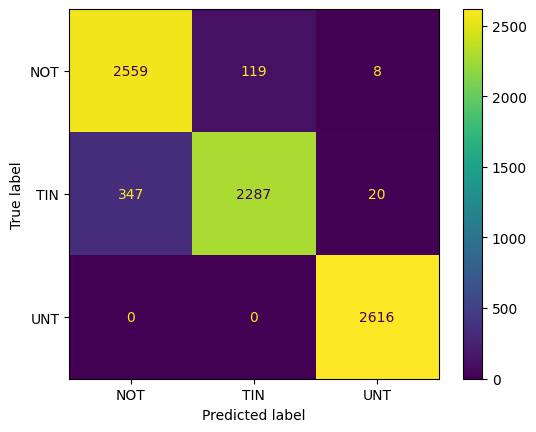

Classification Report:
              precision    recall  f1-score   support

         NOT       0.88      0.95      0.92      2686
         TIN       0.95      0.86      0.90      2654
         UNT       0.99      1.00      0.99      2616

    accuracy                           0.94      7956
   macro avg       0.94      0.94      0.94      7956
weighted avg       0.94      0.94      0.94      7956



In [ ]:
# Lets convert text to numerical. This vectorizer gives equal weight to all words and proved to perform better
# than tfidVectorizer using (1,1n-gram) in contrast to the SVM which performed better with 2,2 n-gram

vectorizer = CountVectorizer()# default: lowercase=True, ngram_range=(1,1)
vectorizer.fit(X_train_lemmatised_tweets)
# convert train and val tweet data into numeric vectors
X_train = vectorizer.transform(X_train_lemmatised_tweets)
X_val = vectorizer.transform(X_val_lemmatised_tweets)

m8 = get_rf_predictions(X_train, X_val, y_train, y_val)

In [ ]:
X_test = vectorizer.transform(list_lemmatised_tweets_test)
predictions = m8.predict(X_test)
print(predictions)

['NOT' 'NOT' 'NOT' 'NOT' 'NOT' 'UNT' 'NOT' 'NOT' 'NOT' 'NOT' 'NOT' 'TIN'
 'NOT' 'NOT' 'TIN' 'TIN' 'NOT' 'NOT' 'NOT' 'NOT' 'NOT' 'NOT' 'NOT' 'NOT'
 'NOT' 'NOT' 'NOT' 'NOT' 'NOT' 'TIN' 'NOT' 'NOT' 'NOT' 'NOT' 'NOT' 'NOT'
 'NOT' 'NOT' 'TIN' 'TIN' 'UNT' 'NOT' 'NOT' 'NOT' 'NOT' 'NOT' 'NOT' 'NOT'
 'NOT' 'NOT' 'NOT' 'NOT' 'NOT' 'NOT' 'NOT' 'NOT' 'NOT' 'NOT' 'TIN' 'TIN'
 'NOT' 'NOT' 'NOT' 'TIN' 'NOT' 'NOT' 'NOT' 'NOT' 'NOT' 'NOT' 'NOT' 'NOT'
 'NOT' 'NOT' 'NOT' 'TIN' 'NOT' 'NOT' 'NOT' 'NOT' 'NOT' 'TIN' 'NOT' 'NOT'
 'NOT' 'TIN' 'NOT' 'TIN' 'NOT' 'NOT' 'NOT' 'NOT' 'TIN' 'NOT' 'NOT' 'NOT'
 'NOT' 'NOT' 'NOT' 'NOT' 'TIN' 'NOT' 'NOT' 'NOT' 'NOT' 'NOT' 'NOT' 'NOT'
 'NOT' 'NOT' 'NOT' 'NOT' 'NOT' 'NOT' 'NOT' 'NOT' 'NOT' 'NOT' 'NOT' 'NOT'
 'NOT' 'NOT' 'NOT' 'NOT' 'NOT' 'NOT' 'NOT' 'NOT' 'NOT' 'NOT' 'NOT' 'NOT'
 'TIN' 'NOT' 'NOT' 'TIN' 'NOT' 'NOT' 'TIN' 'TIN' 'NOT' 'NOT' 'NOT' 'NOT'
 'NOT' 'NOT' 'NOT' 'NOT' 'NOT' 'NOT' 'NOT' 'NOT' 'NOT' 'NOT' 'TIN' 'NOT'
 'TIN' 'NOT' 'NOT' 'NOT' 'NOT' 'NOT' 'NOT' 'NOT' 'N

In [ ]:
df_test['prediction'] = predictions

In [ ]:
df_test.head()

,id,tweet,Tokenized_Tweets,Lemmatised_Tweet,prediction
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,#whoisq #wherestheserver #dumpnike #declasfisa...,#whoisq #wherestheserver #dumpnike #declasfisa...,NOT
1,27014,"#ConstitutionDay is revered by Conservatives, ...","#constitutionday is revered by conservatives ,...","#constitutionday is revered by conservative , ...",NOT
2,30530,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...,#foxnews #nra #maga #potus #trump #2ndamendmen...,#foxnews #nra #maga #potus #trump #2ndamendmen...,NOT
3,13876,#Watching #Boomer getting the news that she is...,#watching #boomer getting the news that she is...,#watching #boomer getting the news that she is...,NOT
4,60133,#NoPasaran: Unity demo to oppose the far-right...,#nopasaran : unity demo to oppose the far-righ...,#nopasaran : unity demo to oppose the far-righ...,NOT


In [ ]:
df_test = df_test[['id', 'prediction']]

In [ ]:
data = []
for index, row in df_test.iterrows():
  data.append({'id': row['id'], 'prediction': row['prediction']})

print(data[0:5])

[{'id': 15923, 'prediction': 'NOT'}, {'id': 27014, 'prediction': 'NOT'}, {'id': 30530, 'prediction': 'NOT'}, {'id': 13876, 'prediction': 'NOT'}, {'id': 60133, 'prediction': 'NOT'}]


In [ ]:
import json

submission_file_path = 'submission_RE.json'
with open(submission_file_path, 'w') as fp:
  for i in data:
    fp.write(json.dumps(i) + '\n')

Conclusion
Random Forest algorithm performed well in accuracy classified 347 Targeted insult tweets as Not offensive. Although a small relative amount it could be damaging.
Future experiments would include spending more time to apply model tuning to optimise performance and further improve accuracy